In [0]:
# Initialisation du notebook en important les différents modules nécessaires
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from collections import OrderedDict

# Initialisation du client PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Importation des modules Python nécessaires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import re
import time

from sklearn import neighbors, metrics,preprocessing,model_selection,linear_model,dummy,svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.model_selection import GridSearchCV,train_test_split,KFold,cross_val_score,StratifiedKFold
from sklearn.neural_network import MLPRegressor

import warnings
warnings.simplefilter('ignore')

Ce notebook est la premère partie du projet 4 du parcours Data Scientist. Ce projet a pour client la ville de Seattle, qui souhaite atteindre l'objectif d'être une ville neutre en émissions de carbone en 2050. Pour ce faire, nous nous basons sur l'étude de la consommation des bâtements non destinés à l'habitation, afin d'en prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées, ainsi que d'évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions. Ainsi, il nous a été donné comme fichiers les benchmarks de consommation d'énergie en 2015 et 2016, mais l'objectif est d'obtenir les prédictions pour le futur sans ce genre de relevés, coûteux à obtenir et pour éviter les fuites de données. 

Ce deuxième fichier va servir à appliquer les modèles sur les données préparées précédemment.

<h2>Sommaire</h2>


1. Application de modèles pour la consommation d'énergie par pied carré

  A. Création des données pour l'application des modèles

  B. Les modèles

    1. k-NN

    2. Régression "dummy"

    3. Régression linéaire

    4. Regression ridge

    5. Lasso

    6. SVR (Epsilon-Support Vector Regression)

    7. MLP (Multi-layer Perceptron regressor)

    8. Random Forest

  C. Comparaison des modèles

  D. Optimisation du modèle sélectionné

2. Application de modèles pour les émission de CO2 par pied carré

  A. Création des données pour l'application des modèles

  B. Les modèles

    1. k-NN

    2. Régression "dummy"

    3. Régression linéaire

    4. Regression ridge

    5. Lasso

    6. SVR (Epsilon-Support Vector Regression)

    7. MLP (Multi-layer Perceptron regressor)

    8. Random Forest

  C. Comparaison des modèles

  D. Optimisation du modèle sélectionné
  

In [2]:
# Importation des données dans le notebook, à partir du Google Drive

link1="https://drive.google.com/open?id=1hPUotB-TTmhH71Wb1h8NZLFhzVkXITct"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('datatrait.csv')  
data = pd.read_csv('datatrait.csv',sep='\t') # \t pour la tabulation
print ("Data importées")

Data importées


# Application de modèles pour la consommation d'énergie par pied carré

<h3>Création des données pour l'application des modèles</h3>

La première chose à faire pour chercher le meilleur modèle est de définir les variables sur lesquelles seront appliquées ces modèles.

Pour commencer, nous savons que beaucoup de bâtiments sont présents en deux exemplaires : un pour 2015, un pour 2016. Il serait donc intéressant de ne pas avoir de doublon dans l'échantillon sélectionné, afin de ne pas biaiser le modèle. Nous sélectionnons donc l'année 2016 grâce à notre variable rajoutée. Nous retirons ensuite cette variable rajoutée ainsi que les variables non numériques ne pouvant donc être utilisées pour nos modèles.

Notre variable à définir (le Y) est donc la consommation d'énergie par pied carré, à savoir la variable "SiteEUIWN", et nos variables sur lesquelles le modèle va se baser sont toutes celles hors consommations globales d'énergie, les émissions de gaz à effet de serre et l'ID.

Nous effections ensuite une stratification par les quartiles, afin de stabiliser l'échantillonnage. Cet échantillonage se fait sur une base de 80% des données dans le train, et tous les bâtiments non considérés dans l'échantillon train sont dans le test. Le paramètre "random_state" nous permet de conserver cet échantillonnage en cas de relance du code.

Après avoir sélectionné nos échantillons, nous calculons l'importance des features dans le calcul de la consommation d'énergie. Pour cela, nous utilisons la fonction "feature_importances_" du modèle de random forest. Ainsi, nous pouvons voir que la variable "ENERGYSTARScore" est la plus importante (35%), donc doit être conservée, même si son calcul est fastidieux.

Nous définissions des variables pouvant être communes à plusieurs modèles, afin de préparer leur potentielle future utilisation.

Enfin, les données en X nécessitent d'être "scalées" pour y appliquer les modèles, ce que nous faisons. Nous avons également essayé d'effectuer une PCA pour réduire le nombre de variables, mais plusieurs tests ont montré que cela n'était pas nécessaire voire baissait la qualité des modèles calculés : nous n'en utilisons donc pas ici.



In [0]:
# Préparation des variables d'application des modèles 

masque=(data["Year"]==2016)
datamodel=data[masque]

datamodel=datamodel.drop(["Location","BuildingType","PropertyName","Year"], axis=1)


for column in datamodel:
  masque=(datamodel[column].notna())
  datamodel=datamodel[masque]

# Choix de notre échantillon
X=datamodel
y=X["SiteEUIWN(kBtu/sf)"]
X=X.drop(['SiteEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)','TotalGHGEmissions','GHGEmissionsIntensity',"ID"],axis=1)

datatest=data.iloc[1:5,:]

y_binned=pd.qcut(y, 4)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,y, train_size=0.8, stratify=y_binned,random_state=0)

In [4]:
for i in datatest :
  print (i)
print (len(data))
print (len(datatest.columns))

for x in datatest.itertuples():
    print(x)

BuildingType
ENERGYSTARScore
ElectricityTauxConsom
GFA
GHGEmissionsIntensity
ID
Location
NaturalGasTauxConsom
OtherFuelUseTauxConsom
PropertyName
SiteEUIWN(kBtu/sf)
SiteEnergyUseWN(kBtu)
SteamUseTauxConsom
TotalGHGEmissions
Year
YearBuilt
BuildingsLN
FloorsLN
Neighborhood_BALLARD
Neighborhood_CENTRAL
Neighborhood_DELRIDGE
Neighborhood_DOWNTOWN
Neighborhood_EAST
Neighborhood_GREATER DUWAMISH
Neighborhood_LAKE UNION
Neighborhood_MAGNOLIA / QUEEN ANNE
Neighborhood_NORTH
Neighborhood_NORTHEAST
Neighborhood_NORTHWEST
Neighborhood_SOUTHEAST
Neighborhood_SOUTHWEST
CouncilDistrictCode_1
CouncilDistrictCode_2
CouncilDistrictCode_3
CouncilDistrictCode_4
CouncilDistrictCode_5
CouncilDistrictCode_6
CouncilDistrictCode_7
_Adult Education
_Automobile Dealership
_Bank Branch
_College/University
_Convention Center
_Courthouse
_Data Center
_Distribution Center
_Financial Office
_Fire Station
_Fitness Center/Health Club/Gym
_Food Service
_Hospital (General Medical & Surgical)
_Hotel
_K-12 School
_Labora

In [5]:
sel = RandomForestRegressor()
sel.fit(Xtrain, Ytrain)
feature_importances = pd.DataFrame(sel.feature_importances_,index = Xtrain.columns,columns=['importance']).sort_values('importance',ascending=False)
print (feature_importances)

                                             importance
_Data Center                                   0.621129
ENERGYSTARScore                                0.253983
_Parking                                       0.045003
ElectricityTauxConsom                          0.017505
_Office                                        0.011940
...                                                 ...
_Fire Station                                  0.000000
_Automobile Dealership                         0.000000
_K-12 School                                   0.000000
_Hospital (General Medical & Surgical)         0.000000
_Outpatient Rehabilitation/Physical Therapy    0.000000

[94 rows x 1 columns]


In [6]:
Xtrain=Xtrain.values
Xtest=Xtest.values


n_alphas = 300
alphas = np.logspace(-4, 4, n_alphas)
print ("Alphas entre ",min(alphas)," et ",max(alphas))

folds= KFold(n_splits=5,shuffle=False)

Alphas entre  0.0001  et  10000.0


In [0]:
std_scale = preprocessing.StandardScaler().fit(Xtrain)
Xtrain_scaled = std_scale.transform(Xtrain)
Xtest_scaled= std_scale.transform(Xtest)

In [0]:

'''
pca = PCA(n_components=None)
pca.fit(Xtrain_scaled)
print ("Variance expliquée sur les données complètes de consommations d'énergie : ",np.cumsum(pca.explained_variance_ratio_))

x=np.cumsum(pca.explained_variance_ratio_)
y=range(0,len(x))
sns.set()
plt.plot(x,y)
plt.xlabel("Variance expliquée")
plt.ylabel("Nombre de variables")
plt.show()

sns.set()
plt.plot(x,y)
plt.xlabel("Variance expliquée")
plt.ylabel("Nombre de variables")
plt.xlim(0.75,0.85)
plt.ylim(30,50)
plt.show()

pca_final=PCA(n_components=0.94) 
Xtrain_projected = pca_final.fit_transform(Xtrain_scaled) # Projection de notre X sur les PCs
Xtest_projected = pca_final.transform(Xtest_scaled)
'''

'\npca = PCA(n_components=None)\npca.fit(Xtrain_scaled)\nprint ("Variance expliquée sur les données complètes de consommations d\'énergie : ",np.cumsum(pca.explained_variance_ratio_))\n\nx=np.cumsum(pca.explained_variance_ratio_)\ny=range(0,len(x))\nsns.set()\nplt.plot(x,y)\nplt.xlabel("Variance expliquée")\nplt.ylabel("Nombre de variables")\nplt.show()\n\nsns.set()\nplt.plot(x,y)\nplt.xlabel("Variance expliquée")\nplt.ylabel("Nombre de variables")\nplt.xlim(0.75,0.85)\nplt.ylim(30,50)\nplt.show()\n\npca_final=PCA(n_components=0.94) \nXtrain_projected = pca_final.fit_transform(Xtrain_scaled) # Projection de notre X sur les PCs\nXtest_projected = pca_final.transform(Xtest_scaled)\n'

<h3>k-NN</h3>

Nous commençons par tester le k Nearest Neighbors (ou k-NN) qui va calculer les valeurs recherchées en utilisant les k données voisines les plus proches. Pour cela, pour harmoniser tous les modèles, nous utilisons le GridSearchCV qui permet en même temps une cross-validation donc des résultats plus fiables. 

Pour le k-NN, il n'existe qu'un unique hyper-paramètre sur lequel nous pouvons jouer pour optimiser notre modèle : le nombre de voisins à sélectionner pour chacune des valeurs à calculer. Nous choisissons un intervalle assez grand pour ce paramètre, vu que nous testons le modèle pour un nombre allant de 1 à 30. 

Une fois le calcul effectué, nous visualisons le nombre de voisins pour lequel les résultats sont optimaux.

Nous avons aussi enregistré plusieurs valeurs, comme pour chacun des modèles que nous calculerons, et en double (le train et le test), afin de comparer l'efficacité de tous les modèles testés ici :
- le temps d'exécution du modèle (entre le tout début et la fin des predicts)
- le score : ici, nous utiliserons le R2
- la RMSE : racine carrée du carré moyen des erreurs, qui doit être la plus basse possible 
- la MAE : moyenne arithmétique des valeurs absolues des écarts

Nous affichons enfin graphiquement les scores R2 du train et du test selon le nombre de voisins utilisés.

In [8]:
start_time=time.time()

# k-NN de régression
parameters = {'n_neighbors': list(range(1,30))}

model=neighbors.KNeighborsRegressor()
knnreg = GridSearchCV(cv=folds,estimator=model,param_grid=parameters,return_train_score=True)
knnreg.fit(Xtrain_scaled,Ytrain)

knntime=time.time()-start_time

resknn = knnreg.cv_results_
k_knn = resknn['param_n_neighbors']
train_score_knn = resknn['mean_train_score']
test_score_knn = resknn['mean_test_score']

print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",knnreg.best_params_)


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'n_neighbors': 12}


In [9]:
print ("Valeurs pour le k-NN sur le train")
knnpredtrain= knnreg.predict(Xtrain_scaled)
knnpredtrainrmse=np.sqrt(mean_squared_error(Ytrain,knnpredtrain))
print("RMSE = ",knnpredtrainrmse)
knnpredtrainr2=r2_score(Ytrain, knnpredtrain)
print("R2 score = ",knnpredtrainr2)
knnpredtrainmae= mean_absolute_error(Ytrain,knnpredtrain)
print ("MAE :", knnpredtrainmae)

print ("Valeurs pour le k-NN sur le test")
knnpredtest= knnreg.predict(Xtest_scaled)
knnpredtestrmse=np.sqrt(mean_squared_error(Ytest,knnpredtest))
print("RMSE = ",knnpredtestrmse)
knnpredtestr2=r2_score(Ytest, knnpredtest)
print("R2 score = ",knnpredtestr2)
knnpredtestmae= mean_absolute_error(Ytest,knnpredtest)
print ("MAE :", knnpredtestmae)

knnstats=["k-NN",knnpredtrainr2,knnpredtrainrmse,knnpredtrainmae,knnpredtestr2,knnpredtestrmse,knnpredtestmae,knntime]



Valeurs pour le k-NN sur le train
RMSE =  63.71193866862443
R2 score =  0.23103160064873363
MAE : 27.139518319147133
Valeurs pour le k-NN sur le test
RMSE =  44.076573416204866
R2 score =  0.20478836328723804
MAE : 27.10130236346354


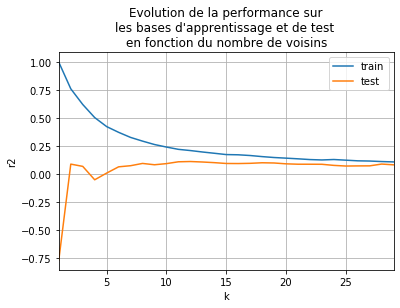

In [10]:
df_score = pd.DataFrame(dict(k=k_knn, test=test_score_knn, train=train_score_knn))
ax = df_score.plot(x='k', y='train', figsize=(6, 4))
df_score.plot(x='k', y='test', ax=ax, grid=True)
ax.set_title("Evolution de la performance sur\nles bases d'apprentissage et de test \nen fonction du nombre de voisins")
ax.set_ylabel("r2");

<h3>Régression "dummy"</h3>

Nous testons le dummy regressor (dans le GridSearchCV) qui va nous servir de comparateur pour les autres modèles, comme modèle obtenant les pires résultats. 

Pour le dummy regressor, il n'existe qu'un unique hyper-paramètre sur lequel nous pouvons jouer pour optimiser notre modèle : la stratégie utilisée pour faire le calcul. Ici, nous en sélectionnons deux différentes : la moyenne (les résultats sont égaux à la moyenne de l'échantillon train) et la médiane (les résultats sont égaux à la médiane de l'échantillon train)

Une fois le calcul effectué, nous visualisons la stratégie pour laquelle les résultats sont "optimaux".

Nous avons aussi enregistré plusieurs valeurs, comme pour chacun des modèles que nous calculerons, et en double (le train et le test), afin de comparer l'efficacité de tous les modèles testés ici : 
- le temps d'exécution du modèle (entre le tout début et la fin des predicts)
- le score : ici, nous utiliserons le R2
- la RMSE : racine carrée du carré moyen des erreurs, qui doit être la plus basse possible 
- la MAE : moyenne arithmétique des valeurs absolues des écarts

In [11]:
start_time=time.time()

parameters = {'strategy':["mean","median"]}

model = dummy.DummyRegressor()
du=GridSearchCV(cv=folds, estimator=model,param_grid=parameters,return_train_score=True)
du.fit(Xtrain_scaled,Ytrain)

dutime=time.time()-start_time

resdu = du.cv_results_
train_score_du = resdu['mean_train_score']
test_score_du = resdu['mean_test_score']

print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",du.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'strategy': 'median'}


In [12]:
print ("Valeurs pour le dummy regressor sur le train")
dupredtrain= du.predict(Xtrain_scaled)
dupredtrainrmse=np.sqrt(mean_squared_error(Ytrain,dupredtrain))
print("RMSE = ",dupredtrainrmse)
dupredtrainr2=r2_score(Ytrain, dupredtrain)
print("R2 score = ",dupredtrainr2)
dupredtrainmae= mean_absolute_error(Ytrain,dupredtrain)
print ("MAE :", dupredtrainmae)

print ("Valeurs pour le dummy regressor sur le test")
dupredtest= du.predict(Xtest_scaled)
dupredtestrmse=np.sqrt(mean_squared_error(Ytest,dupredtest))
print("RMSE = ",dupredtestrmse)
dupredtestr2=r2_score(Ytest, dupredtest)
print("R2 score = ",dupredtestr2)
dupredtestmae= mean_absolute_error(Ytest,dupredtest)
print ("MAE :", dupredtestmae)

dustats=["Dummy regressor",dupredtrainr2,dupredtrainrmse,dupredtrainmae,dupredtestr2,dupredtestrmse,dupredtestmae,dutime]

Valeurs pour le dummy regressor sur le train
RMSE =  75.15767440137405
R2 score =  -0.0700732779595501
MAE : 32.38281252953125
Valeurs pour le dummy regressor sur le test
RMSE =  51.98136174785937
R2 score =  -0.1060184782556508
MAE : 30.162500141875


<h3>Régression linéaire</h3>

Nous testons ensuite la régression linéaire (dans le GridSearchCV) qui permet de contraindre les données à une forme de droite

Pour la régression linéaire, il existe deux hyper-paramètres sur lequel nous pouvons jouer pour optimiser notre modèle : 
- "fit_intercept" afin de savoir si on utilise ou non l'ordonnée à l'origine
- "normalize" afin de normaliser ou non le X avant la régression 

Une fois le calcul effectué, nous visualisons les hyperparamètres pour lesquels les résultats sont "optimaux".

Nous avons aussi enregistré plusieurs valeurs, comme pour chacun des modèles que nous calculerons, et en double (le train et le test), afin de comparer l'efficacité de tous les modèles testés ici : 
- le temps d'exécution du modèle (entre le tout début et la fin des predicts)
- le score : ici, nous utiliserons le R2
- la RMSE : racine carrée du carré moyen des erreurs, qui doit être la plus basse possible 
- la MAE : moyenne arithmétique des valeurs absolues des écarts

In [13]:
start_time=time.time()

parameters = {'fit_intercept':[True,False],'normalize':[True,False]}

model=linear_model.LinearRegression()
lr = GridSearchCV(cv=folds,estimator=model,param_grid=parameters,return_train_score=True)
lr.fit(Xtrain_scaled,Ytrain)

lrtime=time.time()-start_time

reslr = lr.cv_results_
train_score_lr = reslr['mean_train_score']
test_score_lr = reslr['mean_test_score']

print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",lr.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'fit_intercept': True, 'normalize': False}


In [14]:
print ("Valeurs pour la régression linéaire sur le train")
lrpredtrain= lr.predict(Xtrain_scaled)
lrpredtrainrmse=np.sqrt(mean_squared_error(Ytrain,lrpredtrain))
print("RMSE = ",lrpredtrainrmse)
lrpredtrainr2=r2_score(Ytrain, lrpredtrain)
print("R2 score = ",lrpredtrainr2)
lrpredtrainmae= mean_absolute_error(Ytrain,lrpredtrain)
print ("MAE :", lrpredtrainmae)

print ("Valeurs pour la régression linéaire sur le test")
lrpredtest= lr.predict(Xtest_scaled)
lrpredtestrmse=np.sqrt(mean_squared_error(Ytest,lrpredtest))
print("RMSE = ",lrpredtestrmse)
lrpredtestr2=r2_score(Ytest, lrpredtest)
print("R2 score = ",lrpredtestr2)
lrpredtestmae= mean_absolute_error(Ytest,lrpredtest)
print ("MAE :", lrpredtestmae)

lrstats=["Régression linéaire",lrpredtrainr2,lrpredtrainrmse,lrpredtrainmae,lrpredtestr2,lrpredtestrmse,lrpredtestmae,lrtime]

Valeurs pour la régression linéaire sur le train
RMSE =  18.834454372187913
R2 score =  0.932799432744466
MAE : 11.233102481743447
Valeurs pour la régression linéaire sur le test
RMSE =  242701525565800.22
R2 score =  -2.4110826077826487e+25
MAE : 59173726986770.46


<h3>Regression ridge</h3>

Nous testons ensuite la regression ridge (dans le GridSearchCV) qui permet de restreindre l'amplitude des poids avec un effet de sélection groupée : les variables corrélées auront le même coefficient. Ainsi, les variables corrélées vont se combiner et se renforcer mutuellement.

Pour la regression ridge, il existe trois hyper-paramètres sur lequel nous pouvons jouer pour optimiser notre modèle : 
- "alpha" qui est la force de régularisation, afin de réduire la variance des estimations, que nous allons modifier pour cet essai de modèle.
- "fit_intercept" afin de savoir si on utilise ou non l'ordonnée à l'origine
- "normalize" afin de normaliser ou non le X avant la régression 

Une fois le calcul effectué, nous visualisons les hyperparamètres pour lesquels les résultats sont "optimaux".

Nous avons aussi enregistré plusieurs valeurs, comme pour chacun des modèles que nous calculerons, et en double (le train et le test), afin de comparer l'efficacité de tous les modèles testés ici : 
- le temps d'exécution du modèle (entre le tout début et la fin des predicts)
- le score : ici, nous utiliserons le R2
- la RMSE : racine carrée du carré moyen des erreurs, qui doit être la plus basse possible 
- la MAE : moyenne arithmétique des valeurs absolues des écarts

In [15]:
start_time=time.time()

parameters = {'alpha':alphas}
model=Ridge()
rid = GridSearchCV(cv=folds,estimator=model,param_grid=parameters,return_train_score=True)

rid.fit(Xtrain_scaled,Ytrain)

ridtime=time.time()-start_time

res_rid = rid.cv_results_
alpha_rid=res_rid["param_alpha"]
train_score_rid = res_rid['mean_train_score']
test_score_rid = res_rid['mean_test_score']

print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",rid.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'alpha': 28.72063117797828}


In [16]:
print ("Valeurs pour la regression ridge sur le train")
ridpredtrain= rid.predict(Xtrain_scaled)
ridpredtrainrmse=np.sqrt(mean_squared_error(Ytrain,ridpredtrain))
print("RMSE = ",ridpredtrainrmse)
ridpredtrainr2=r2_score(Ytrain, ridpredtrain)
print("R2 score = ",ridpredtrainr2)
ridpredtrainmae= mean_absolute_error(Ytrain,ridpredtrain)
print ("MAE :", ridpredtrainmae)

print ("Valeurs pour la regression ridge sur le test")
ridpredtest= rid.predict(Xtest_scaled)
ridpredtestrmse=np.sqrt(mean_squared_error(Ytest,ridpredtest))
print("RMSE = ",ridpredtestrmse)
ridpredtestr2=r2_score(Ytest,ridpredtest)
print("R2 score = ",ridpredtestr2)
ridpredtestmae= mean_absolute_error(Ytest,ridpredtest)
print ("MAE :", ridpredtestmae)

ridstats=["Régression ridge",ridpredtrainr2,ridpredtrainrmse,ridpredtrainmae,ridpredtestr2,ridpredtestrmse,ridpredtestmae,ridtime]

Valeurs pour la regression ridge sur le train
RMSE =  24.079648832797073
R2 score =  0.8901583241040536
MAE : 13.153759983990094
Valeurs pour la regression ridge sur le test
RMSE =  22.54894867652166
R2 score =  0.7918771932850726
MAE : 16.317325649395755


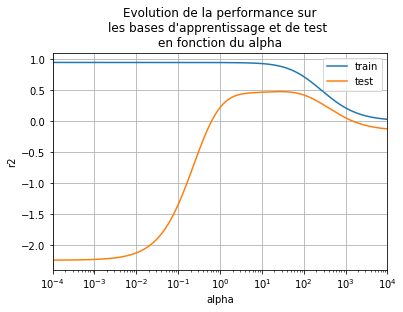

In [17]:
# Représentation graphique de la regression ridge

df_score = pd.DataFrame(dict(alpha=alpha_rid, test=test_score_rid, train=train_score_rid))
ax = df_score.plot(x='alpha', y='train', figsize=(6, 4))
ax.set_xscale('log')
df_score.plot(x='alpha', y='test', ax=ax, grid=True)
ax.set_title("Evolution de la performance sur\nles bases d'apprentissage et de test \nen fonction du alpha")
ax.set_ylabel("r2");

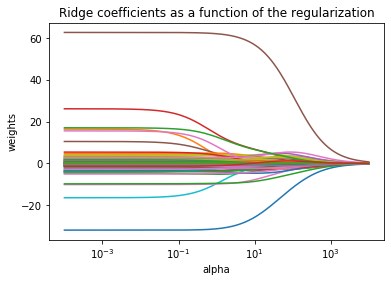

In [18]:
baseline_error = np.mean((lr.predict(Xtest_scaled) - Ytest) ** 2)

ridge = Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(Xtrain_scaled, Ytrain)
    coefs.append(ridge.coef_)
    errors.append([baseline_error, np.mean((ridge.predict(Xtest_scaled) - Ytest) ** 2)])
    
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

<h3>Lasso</h3>

Nous testons ensuite le lasso (dans le GridSearchCV) qui permet de réduire le nombre de variables : les variables qui auront un coefficient égal à zéro ne feront plus partie du modèle.

Pour le lasso, il existe deux hyper-paramètres sur lequel nous pouvons jouer pour optimiser notre modèle : 
- "alpha" qui est la force de régularisation, afin de réduire la variance des estimations
- "normalize" afin de normaliser ou non le X avant la régression 

Une fois le calcul effectué, nous visualisons les hyperparamètres pour lesquels les résultats sont "optimaux".

Nous avons aussi enregistré plusieurs valeurs, comme pour chacun des modèles que nous calculerons, et en double (le train et le test), afin de comparer l'efficacité de tous les modèles testés ici : 
- le temps d'exécution du modèle (entre le tout début et la fin des predicts)
- le score : ici, nous utiliserons le R2
- la RMSE : racine carrée du carré moyen des erreurs, qui doit être la plus basse possible 
- la MAE : moyenne arithmétique des valeurs absolues des écarts

In [19]:
start_time=time.time()

parameters = {'alpha':alphas}

model=Lasso()
las = GridSearchCV(cv=folds, estimator=model,param_grid=parameters,return_train_score=True)
las.fit(Xtrain_scaled,Ytrain)

lastime=time.time()-start_time

res_las = las.cv_results_
alpha_las=res_las["param_alpha"]
train_score_las = res_las['mean_train_score']
test_score_las = res_las['mean_test_score']

print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",las.best_params_)


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'alpha': 3.9995090972036613}


In [20]:
print ("Valeurs pour le lasso sur le train")
laspredtrain= las.predict(Xtrain_scaled)
laspredtrainrmse=np.sqrt(mean_squared_error(Ytrain,laspredtrain))
print("RMSE = ",laspredtrainrmse)
laspredtrainr2=r2_score(Ytrain, laspredtrain)
print("R2 score = ",laspredtrainr2)
laspredtrainmae= mean_absolute_error(Ytrain,laspredtrain)
print ("MAE :", laspredtrainmae)

print ("Valeurs pour le lasso sur le test")
laspredtest= las.predict(Xtest_scaled)
laspredtestrmse=np.sqrt(mean_squared_error(Ytest,laspredtest))
print("RMSE = ",laspredtestrmse)
laspredtestr2=r2_score(Ytest,laspredtest)
print("R2 score = ",laspredtestr2)
laspredtestmae= mean_absolute_error(Ytest,laspredtest)
print ("MAE :", laspredtestmae)

lasstats=["Lasso",laspredtrainr2,laspredtrainrmse,laspredtrainmae,laspredtestr2,laspredtestrmse,laspredtestmae,lastime]

Valeurs pour le lasso sur le train
RMSE =  25.01600374182483
R2 score =  0.8814496832398195
MAE : 15.469110520657388
Valeurs pour le lasso sur le test
RMSE =  34.96505819243294
R2 score =  0.49957892834139284
MAE : 23.009713030339405


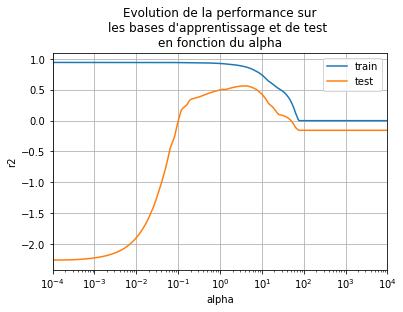

In [21]:
#Représentation graphique du lasso

df_score = pd.DataFrame(dict(alpha=alpha_las, test=test_score_las, train=train_score_las))
ax = df_score.plot(x='alpha', y='train', figsize=(6, 4))
ax.set_xscale('log')
df_score.plot(x='alpha', y='test', ax=ax, grid=True)
ax.set_title("Evolution de la performance sur\nles bases d'apprentissage et de test \nen fonction du alpha")
ax.set_ylabel("r2");

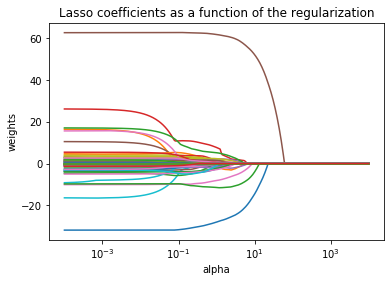

In [22]:
baseline_error = np.mean((lr.predict(Xtest_scaled) - Ytest) ** 2)

lasso = Lasso()

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xtrain_scaled, Ytrain)
    coefs.append(lasso.coef_)
    errors.append([baseline_error, np.mean((lasso.predict(Xtest_scaled) - Ytest) ** 2)])
    
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

<h3>SVR (Epsilon-Support Vector Regression)</h3>

Nous testons ensuite le SVR (dans le GridSearchCV) qui permet de prédire une variable continue, en essayant de se caler au mieux sur une ligne d'erreur seuil. Pour cela, un SVR classifie toutes les prédictions en deux catégories : celles restant dans le domaine d'erreur, et celles ne le respectant pas.

Pour le SVR, il existe trois hyper-paramètres sur lesquels nous pouvons jouer pour optimiser notre modèle : 
- le kernel est le noyau utilisé pour effectuer le calcul dans le modèle
- "C" ou le paramètre d'erreur
- "gamma" ou le coefficient du kernel. Plus il est haut et plus chaque valeur d'entraînement est forte.

Une fois le calcul effectué, nous visualisons les hyperparamètres pour lesquels les résultats sont "optimaux".

Nous avons aussi enregistré plusieurs valeurs, comme pour chacun des modèles que nous calculerons, et en double (le train et le test), afin de comparer l'efficacité de tous les modèles testés ici : 
- le temps d'exécution du modèle (entre le tout début et la fin des predicts)
- le score : ici, nous utiliserons le R2
- la RMSE : racine carrée du carré moyen des erreurs, qui doit être la plus basse possible 
- la MAE : moyenne arithmétique des valeurs absolues des écarts

In [23]:
start_time=time.time()

parameters = {'kernel':['linear','poly','rbf','sigmoid'],'gamma':['auto_deprecated'],'C':[1.0]}

model=svm.SVR()
svr_model = GridSearchCV(cv=folds,estimator=model,param_grid=parameters,return_train_score=True)
svr_model.fit(Xtrain_scaled,Ytrain)

svrtime=time.time()-start_time

res_svr= svr_model.cv_results_
train_score_svr= res_svr['mean_train_score']
test_score_svr = res_svr['mean_test_score']
C_svr=res_svr['param_C']
gamma_svr=res_svr['param_gamma']

print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",svr_model.best_params_)


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'C': 1.0, 'gamma': 'auto_deprecated', 'kernel': 'linear'}


In [24]:
print ("Valeurs pour le SVR sur le train")
svrpredtrain= svr_model.predict(Xtrain_scaled)
svrpredtrainrmse=np.sqrt(mean_squared_error(Ytrain,svrpredtrain))
print("RMSE = ",svrpredtrainrmse)
svrpredtrainr2=r2_score(Ytrain, svrpredtrain)
print("R2 score = ",svrpredtrainr2)
svrpredtrainmae= mean_absolute_error(Ytrain,svrpredtrain)
print ("MAE :", svrpredtrainmae)

print ("Valeurs pour le SVR sur le test")
svrpredtest= svr_model.predict(Xtest_scaled)
svrpredtestrmse=np.sqrt(mean_squared_error(Ytest,svrpredtest))
print("RMSE = ",svrpredtestrmse)
svrpredtestr2=r2_score(Ytest,svrpredtest)
print("R2 score = ",svrpredtestr2)
svrpredtestmae= mean_absolute_error(Ytest,svrpredtest)
print ("MAE :", svrpredtestmae)

svrstats=["SVR",svrpredtrainr2,svrpredtrainrmse,svrpredtrainmae,svrpredtestr2,svrpredtestrmse,svrpredtestmae,svrtime]

Valeurs pour le SVR sur le train
RMSE =  49.37841099323663
R2 score =  0.5381073275027355
MAE : 14.421165113997379
Valeurs pour le SVR sur le test
RMSE =  19.072179281899356
R2 score =  0.8511092495387445
MAE : 13.503284203634287


<h3>MLP (Multi-layer Perceptron regressor)</h3>

Nous testons ensuite le MLP (dans le GridSearchCV) qui utilise un réseau de neurones à propagation avant. il prend donc les échantillons d'entrée et utilise des couches de neurones pour effectuer les calculs.

Pour le MLP, il existe 4 hyper-paramètres sur lesquels nous pouvons jouer pour optimiser notre modèle : 
- 'hidden_layer_sizes' ou le nombre de couches et le nombre de neurones de chaque couche
- "activation" ou les différents types de fonctions des couches renvoyant différentes fonctions
- "solver" pour l'optimisation des poids
- "alpha" qui est la force de régularisation, afin de réduire la variance des estimations, mais à une échelle différente des modèles précédents

Une fois le calcul effectué, nous visualisons les hyperparamètres pour lesquels les résultats sont "optimaux".

Nous avons aussi enregistré plusieurs valeurs, comme pour chacun des modèles que nous calculerons, et en double (le train et le test), afin de comparer l'efficacité de tous les modèles testés ici : 
- le temps d'exécution du modèle (entre le tout début et la fin des predicts)
- le score : ici, nous utiliserons le R2
- la RMSE : racine carrée du carré moyen des erreurs, qui doit être la plus basse possible 
- la MAE : moyenne arithmétique des valeurs absolues des écarts

In [25]:
start_time=time.time()

parameters = {'hidden_layer_sizes':[(50,),(50,50)],'activation':['identity','logistic','tanh','relu'],'solver':['lbfgs','adam']}
model=MLPRegressor()
mlp=GridSearchCV(cv=folds, estimator=model,param_grid=parameters,return_train_score=True)
mlp.fit(Xtrain_scaled,Ytrain)

mlptime=time.time()-start_time

res_mlp= mlp.cv_results_
train_score_mlp= res_mlp['mean_train_score']
test_score_mlp = res_mlp['mean_test_score']

print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",mlp.best_params_)


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'solver': 'adam'}


In [26]:
print ("Valeurs pour le MLP sur le train")
mlppredtrain= mlp.predict(Xtrain_scaled)
mlppredtrainrmse=np.sqrt(mean_squared_error(Ytrain,mlppredtrain))
print("RMSE = ",mlppredtrainrmse)
mlppredtrainr2=r2_score(Ytrain, mlppredtrain)
print("R2 score = ",mlppredtrainr2)
mlppredtrainmae= mean_absolute_error(Ytrain,mlppredtrain)
print ("MAE :", mlppredtrainmae)

print ("Valeurs pour le MLP sur le test")
mlppredtest= mlp.predict(Xtest_scaled)
mlppredtestrmse=np.sqrt(mean_squared_error(Ytest,mlppredtest))
print("RMSE = ",mlppredtestrmse)
mlppredtestr2=r2_score(Ytest,mlppredtest)
print("R2 score = ",mlppredtestr2)
mlppredtestmae= mean_absolute_error(Ytest,mlppredtest)
print ("MAE :", mlppredtestmae)

mlpstats=["MLP",mlppredtrainr2,mlppredtrainrmse,mlppredtrainmae,mlppredtestr2,mlppredtestrmse,mlppredtestmae,mlptime]

Valeurs pour le MLP sur le train
RMSE =  39.751250499025204
R2 score =  0.7006574576058234
MAE : 18.40832558576691
Valeurs pour le MLP sur le test
RMSE =  32.589039337096494
R2 score =  0.5652794256868385
MAE : 22.389272728248013


<h3>Random Forest</h3>

Nous testons enfin le RF (dans le GridSearchCV) qui combine de multiples arbres de décision pour fusionner leurs prédictions afin d'obtenir une prédiction finale plus stable et précis.

Pour le RF, il existe 3 hyper-paramètres sur lesquels nous pouvons jouer pour optimiser notre modèle : 
- Le nombre d'estimateurs est le nombre d'arbres de décision utilisés
- Le criterion est la fonction mesurant la qualité d'une décision
- La profondeur maximale des arbres

Une fois le calcul effectué, nous visualisons plusieurs indications :
- La stratégie pour laquelle les résultats sont "optimaux"
- Le score correspondant à chaque stratégie
- Le score correspondant à chacun des 5 tours demandés par la cross-validation, afin de confirmer que la répartition des échantillons se fait de manière homogène

Nous avons aussi enregistré plusieurs valeurs, comme pour chacun des modèles que nous calculerons, et en double (le train et le test), afin de comparer l'efficacité de tous les modèles testés ici : 
- le temps d'exécution du modèle (entre le tout début et la fin des predicts)
- le score : ici, nous utiliserons le R2
- la RMSE : racine carrée du carré moyen des erreurs, qui doit être la plus basse possible 
- la MAE : moyenne arithmétique des valeurs absolues des écarts

In [27]:
start_time=time.time()

parameters = {'n_estimators':[50,100,200],'max_depth':[30,50]}

model=RandomForestRegressor()
rf = GridSearchCV(cv=folds,estimator=model,param_grid=parameters,return_train_score=True)
rf.fit(Xtrain_scaled,Ytrain)

rftime=time.time()-start_time

res_rf= rf.cv_results_
train_score_rf= res_rf['mean_train_score']
test_score_rf = res_rf['mean_test_score']

print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",rf.best_params_)


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'max_depth': 30, 'n_estimators': 200}


In [28]:
print ("Valeurs pour le Random Forest sur le train")
rfpredtrain= rf.predict(Xtrain_scaled)
rfpredtrainrmse=np.sqrt(mean_squared_error(Ytrain,rfpredtrain))
print("RMSE = ",rfpredtrainrmse)
rfpredtrainr2=r2_score(Ytrain, rfpredtrain)
print("R2 score = ",rfpredtrainr2)
rfpredtrainmae= mean_absolute_error(Ytrain,rfpredtrain)
print ("MAE :", rfpredtrainmae)


print ("Valeurs pour le Random Forest sur le test")
rfpredtest= rf.predict(Xtest_scaled)
rfpredtestrmse=np.sqrt(mean_squared_error(Ytest,rfpredtest))
print("RMSE = ",rfpredtestrmse)
rfpredtestr2=r2_score(Ytest,rfpredtest)
print("R2 score = ",rfpredtestr2)
rfpredtestmae= mean_absolute_error(Ytest,rfpredtest)
print ("MAE :", rfpredtestmae)

rfstats=["Random Forest",rfpredtrainr2,rfpredtrainrmse,rfpredtrainmae,rfpredtestr2,rfpredtestrmse,rfpredtestmae,rftime]

Valeurs pour le Random Forest sur le train
RMSE =  16.267179593044418
R2 score =  0.9498707305979474
MAE : 6.641632754292193
Valeurs pour le Random Forest sur le test
RMSE =  38.76605924591104
R2 score =  0.3848650709243464
MAE : 23.56401609965624


<h3>Comparaison des modèles</h3>

Maintenant que nous avons fait tourner tous les modèles pouvant être intéressants pour nos données afin d'obtenir la consommation totale d'énergie par pied carré, nous les comparons pour sélectionner le plus adapté.

Le modèle le plus adapté est donc un modèle possédant un haut score, des valeurs d'erreur basses, ainsi qu'un temps d'exécution correct.

Les plus hauts scores sont obtenus avec le modèle de SVR. En effet, le SVR donne un meilleur score, des taux d'erreurs plus bas et un temps d'exécution rapide : ce sera donc le modèle sélectionné pour calculer la consommation totale d'énergie par pied carré.

In [29]:
statsnom=["Score train","RMSE train","MAE train","Score test","RMSE test","MAE test","Temps d'exécution"]
stats=[statsnom,dustats,knnstats,lrstats,ridstats,lasstats,svrstats,mlpstats,rfstats]

modeles=["Dummy regressor","kNN","Régression linéaire","Regression ridge","Lasso","SVR","MLP","Random Forest"]
scoretrain=[dupredtrainr2,knnpredtrainr2,lrpredtrainr2,ridpredtrainr2,laspredtrainr2,svrpredtrainr2,mlppredtrainr2,rfpredtrainr2]
scoretest=[dupredtestr2,knnpredtestr2,lrpredtestr2,ridpredtestr2,laspredtestr2,svrpredtestr2,mlppredtestr2,rfpredtestr2]

rmsetrain=[dupredtrainrmse,knnpredtrainrmse,lrpredtrainrmse,ridpredtrainrmse,laspredtrainrmse,svrpredtrainrmse,mlppredtrainrmse,rfpredtrainrmse]
rmsetest=[dupredtestrmse,knnpredtestrmse,lrpredtestrmse,ridpredtestrmse,laspredtestrmse,svrpredtestrmse,mlppredtestrmse,rfpredtestrmse]

maetrain=[dupredtrainmae,knnpredtrainmae,lrpredtrainmae,ridpredtrainmae,laspredtrainmae,svrpredtrainmae,mlppredtrainmae,rfpredtrainmae]
maetest=[dupredtestmae,knnpredtestmae,lrpredtestmae,ridpredtestmae,laspredtestmae,svrpredtestmae,mlppredtestmae,rfpredtestmae]

time=[dutime,knntime,lrtime,ridtime,lastime,svrtime,mlptime,rftime]


datamodeles=pd.DataFrame(dict(modeles=modeles, scoretrain=scoretrain,scoretest=scoretest,rmsetrain=rmsetrain,rmsetest=rmsetest,maetrain=maetrain,maetest=maetest,time=time))

print (datamodeles.iloc[:,[0,1,2]])
print ()
print (datamodeles.iloc[:,[0,3,4]])
print ()
print (datamodeles.iloc[:,[0,5,6]])
print ()
print (datamodeles.iloc[:,[0,7]])

               modeles  scoretrain     scoretest
0      Dummy regressor   -0.070073 -1.060185e-01
1                  kNN    0.231032  2.047884e-01
2  Régression linéaire    0.932799 -2.411083e+25
3     Regression ridge    0.890158  7.918772e-01
4                Lasso    0.881450  4.995789e-01
5                  SVR    0.538107  8.511092e-01
6                  MLP    0.700657  5.652794e-01
7        Random Forest    0.949871  3.848651e-01

               modeles  rmsetrain      rmsetest
0      Dummy regressor  75.157674  5.198136e+01
1                  kNN  63.711939  4.407657e+01
2  Régression linéaire  18.834454  2.427015e+14
3     Regression ridge  24.079649  2.254895e+01
4                Lasso  25.016004  3.496506e+01
5                  SVR  49.378411  1.907218e+01
6                  MLP  39.751250  3.258904e+01
7        Random Forest  16.267180  3.876606e+01

               modeles   maetrain       maetest
0      Dummy regressor  32.382813  3.016250e+01
1                  kNN  27.13

<h3>Optimisation possible du modèle sélectionné</h3>

Nous avons donc sélectionné le modèle de SVR comme étant celui donnant les résultats les plus pertinents pour la consommation totale d'énergie par pied carré. Or, ce modèle a trois hyper-paramètres : le kernel, la valeur de C et de la valeur de gamma, ce que nous avons déjà détaillé et étudié auparavant. Nous tâchons donc de trouver le modèle le plus optimal en modifiant les C et les gamma

Nous en profitons cependant pour observer la répartition des scores lors de nos plis : or, ceux-ci ne sont absolument pas stables, allant de -0.40 à 0.52. Pour de futures améliorations de notre modèle, il pourrait être intéressant de stratifier nos données lors de notre séparation en échantillons afin d'obtenir des "catégories" de données plus stables.

In [30]:
print ("\nScores après chaque pli test (ici 5) :")
best_estim_place = np.where(svr_model.cv_results_['rank_test_score'] == 1)[0][0] 
for i in range(5):    
  print(str(i)," : ",svr_model.cv_results_['split' + str(i) + '_test_score'][best_estim_place])



Scores après chaque pli test (ici 5) :
0  :  0.25858892130426114
1  :  0.40939108973691063
2  :  0.5861987120122262
3  :  0.483964177025718
4  :  0.1674687229079065


In [33]:
print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour le SVR testé auparavant :",svr_model.best_params_)
start_time=time.time()

C_range = np.logspace(-1, 1, 30)

parameters = {'kernel':['linear','rbf'],'C':C_range}
model=svm.SVR()
svr_modelopti = GridSearchCV(cv=folds,estimator=model,param_grid=parameters,return_train_score=True)
svr_modelopti.fit(Xtrain_scaled,Ytrain)

svrtime=time.time()-start_time

res_svr= svr_modelopti.cv_results_
train_score_svr= res_svr['mean_train_score']
test_score_svr = res_svr['mean_test_score']

print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",svr_modelopti.best_params_)



Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement pour le SVR testé auparavant : {'C': 1.0, 'gamma': 'auto_deprecated', 'kernel': 'linear'}
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'C': 4.520353656360243, 'kernel': 'linear'}


In [34]:
print ("Valeurs pour le SVR sur le train")
svrpredtrain= svr_modelopti.predict(Xtrain_scaled)
svrpredtrainrmse=np.sqrt(mean_squared_error(Ytrain,svrpredtrain))
print("RMSE = ",svrpredtrainrmse)
svrpredtrainr2=r2_score(Ytrain, svrpredtrain)
print("R2 score = ",svrpredtrainr2)
svrpredtrainmae= mean_absolute_error(Ytrain,svrpredtrain)
print ("MAE :", svrpredtrainmae)
print ("Valeurs pour le SVR sur le test")
svrpredtest= svr_modelopti.predict(Xtest_scaled)
svrpredtestrmse=np.sqrt(mean_squared_error(Ytest,svrpredtest))
print("RMSE = ",svrpredtestrmse)
svrpredtestr2=r2_score(Ytest, svrpredtest)
print("R2 score = ",svrpredtestr2)
svrpredtestmae= mean_absolute_error(Ytest,svrpredtest)
print ("MAE :", svrpredtestmae)


Valeurs pour le SVR sur le train
RMSE =  30.142649743353726
R2 score =  0.8278806463582998
MAE : 10.130064936054126
Valeurs pour le SVR sur le test
RMSE =  19.906510801330295
R2 score =  0.837797566484178
MAE : 15.436075208940537


# Application de modèles pour les émissions de gaz à effet de serre par pied carré

<h3>Création des données pour l'application des modèles</h3>

La première chose à faire pour chercher le meilleur modèle est de définir les variables sur lesquelles seront appliquées ces modèles.

Pour commencer, nous savons que beaucoup de bâtiments sont présents en deux exemplaires : un pour 2015, un pour 2016. Il serait donc intéressant de ne pas avoir de doublon dans l'échantillon sélectionné, afin de ne pas biaiser le modèle. Nous sélectionnons donc l'année 2016 grâce à notre variable rajoutée. Nous retirons ensuite cette variable rajoutée ainsi que les variables non numériques ne pouvant donc être utilisées pour nos modèles.

Notre variable à définir (le Y) est donc la consommation d'énergie par pied carré, à savoir la variable "SiteEUIWN", et nos variables sur lesquelles le modèle va se baser sont toutes celles hors consommations globales d'énergie, les émissions de gaz à effet de serre et l'ID.

Nous effections ensuite une stratification par les quartiles, afin de stabiliser l'échantillonnage. Cet échantillonage se fait sur une base de 80% des données dans le train, et tous les bâtiments non considérés dans l'échantillon train sont dans le test. Le paramètre "random_state" nous permet de conserver cet échantillonnage en cas de relance du code.

Après avoir sélectionné nos échantillons, nous calculons l'importance des features dans le calcul de la consommation d'énergie. Pour cela, nous utilisons la fonction "feature_importances_" du modèle de random forest. Ainsi, nous pouvons voir que la variable "ENERGYSTARScore" est la plus importante (35%), donc doit être conservée, même si son calcul est fastidieux.

Nous définissions des variables pouvant être communes à plusieurs modèles, afin de préparer leur potentielle future utilisation.

Enfin, les données en X nécessitent d'être "scalées" pour y appliquer les modèles, ce que nous faisons. Nous avons également essayé d'effectuer une PCA pour réduire le nombre de variables, mais plusieurs tests ont montré que cela n'était pas nécessaire voire baissait la qualité des modèles calculés : nous n'en utilisons donc pas ici.








In [0]:
# Préparation des variables d'application des modèles 

masque=(data["Year"]==2016)
datamodel=data[masque]

datamodel=datamodel.drop(["Location","BuildingType","PropertyName","Year"], axis=1)
for column in datamodel:
  masque=(datamodel[column].notna())
  datamodel=datamodel[masque]

# Choix de notre échantillon

X=datamodel
y=X["GHGEmissionsIntensity"]
Xdata=X.drop(['SiteEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)','TotalGHGEmissions','GHGEmissionsIntensity',"ID"],axis=1)

datatest=Xdata.iloc[1:5,:]

y_binned=pd.qcut(y, 4)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xdata,y, train_size=0.8, stratify=y_binned,random_state=1)

In [36]:
for i in datatest :
  print (i)
print (len(data))
print (len(datatest.columns))

for x in datatest.itertuples():
    print(x)

ENERGYSTARScore
ElectricityTauxConsom
GFA
NaturalGasTauxConsom
OtherFuelUseTauxConsom
SteamUseTauxConsom
YearBuilt
BuildingsLN
FloorsLN
Neighborhood_BALLARD
Neighborhood_CENTRAL
Neighborhood_DELRIDGE
Neighborhood_DOWNTOWN
Neighborhood_EAST
Neighborhood_GREATER DUWAMISH
Neighborhood_LAKE UNION
Neighborhood_MAGNOLIA / QUEEN ANNE
Neighborhood_NORTH
Neighborhood_NORTHEAST
Neighborhood_NORTHWEST
Neighborhood_SOUTHEAST
Neighborhood_SOUTHWEST
CouncilDistrictCode_1
CouncilDistrictCode_2
CouncilDistrictCode_3
CouncilDistrictCode_4
CouncilDistrictCode_5
CouncilDistrictCode_6
CouncilDistrictCode_7
_Adult Education
_Automobile Dealership
_Bank Branch
_College/University
_Convention Center
_Courthouse
_Data Center
_Distribution Center
_Financial Office
_Fire Station
_Fitness Center/Health Club/Gym
_Food Service
_Hospital (General Medical & Surgical)
_Hotel
_K-12 School
_Laboratory
_Library
_Lifestyle Center
_Manufacturing/Industrial Plant
_Medical Office
_Movie Theater
_Multifamily Housing
_Museum


In [37]:
sel = RandomForestRegressor()
sel.fit(Xtrain, Ytrain)
feature_importances = pd.DataFrame(sel.feature_importances_,index = Xtrain.columns,columns=['importance']).sort_values('importance',ascending=False)
print (feature_importances)

                             importance
_Laboratory                    0.629976
ElectricityTauxConsom          0.201073
ENERGYSTARScore                0.039901
_Parking                       0.023819
YearBuilt                      0.019378
...                                 ...
_Automobile Dealership         0.000000
_Performing Arts               0.000000
_Adult Education               0.000000
_Police Station                0.000000
_Other - Technology/Science    0.000000

[94 rows x 1 columns]


In [38]:
Xtrain=Xtrain.values
Xtest=Xtest.values


n_alphas = 300
alphas = np.logspace(-4, 4, n_alphas)
print ("Alphas entre ",min(alphas)," et ",max(alphas))

folds= KFold(n_splits=5,shuffle=False)

C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-2, 1, 4)

Alphas entre  0.0001  et  10000.0


In [0]:
std_scale = preprocessing.StandardScaler().fit(Xtrain)
Xtrain_scaled = std_scale.transform(Xtrain)
Xtest_scaled= std_scale.transform(Xtest)

In [40]:
'''
pca = PCA(n_components=None)
pca.fit(Xtrain_scaled)
print ("Variance expliquée sur les données complètes de consommations d'énergie : ",np.cumsum(pca.explained_variance_ratio_))

x=np.cumsum(pca.explained_variance_ratio_)
y=range(0,len(x))
sns.set()
plt.plot(x,y)
plt.xlabel("Variance expliquée")
plt.ylabel("Nombre de variables")
plt.show()

sns.set()
plt.plot(x,y)
plt.xlabel("Variance expliquée")
plt.ylabel("Nombre de variables")
plt.xlim(0.80,1.0)
plt.ylim(30,60)
plt.show()

pca_final=PCA(n_components=0.94) 
Xtrain_projected = pca_final.fit_transform(Xtrain_scaled) # Projection de notre X sur les PCs
Xtest_projected = pca_final.transform(Xtest_scaled)
'''

'\npca = PCA(n_components=None)\npca.fit(Xtrain_scaled)\nprint ("Variance expliquée sur les données complètes de consommations d\'énergie : ",np.cumsum(pca.explained_variance_ratio_))\n\nx=np.cumsum(pca.explained_variance_ratio_)\ny=range(0,len(x))\nsns.set()\nplt.plot(x,y)\nplt.xlabel("Variance expliquée")\nplt.ylabel("Nombre de variables")\nplt.show()\n\nsns.set()\nplt.plot(x,y)\nplt.xlabel("Variance expliquée")\nplt.ylabel("Nombre de variables")\nplt.xlim(0.80,1.0)\nplt.ylim(30,60)\nplt.show()\n\npca_final=PCA(n_components=0.94) \nXtrain_projected = pca_final.fit_transform(Xtrain_scaled) # Projection de notre X sur les PCs\nXtest_projected = pca_final.transform(Xtest_scaled)\n'

<h3>k-NN</h3>

Nous commençons par tester le k Nearest Neighbors (ou k-NN) qui va calculer les valeurs recherchées en utilisant les k données voisines les plus proches. Pour cela, pour harmoniser tous les modèles, nous utilisons le GridSearchCV qui permet en même temps une cross-validation donc des résultats plus fiables. 

Pour le k-NN, il n'existe qu'un unique hyper-paramètre sur lequel nous pouvons jouer pour optimiser notre modèle : le nombre de voisins à sélectionner pour chacune des valeurs à calculer. Nous choisissons un intervalle assez grand pour ce paramètre, vu que nous testons le modèle pour un nombre allant de 1 à 30. 

Une fois le calcul effectué, nous visualisons le nombre de voisins pour lequel les résultats sont optimaux.

Nous avons aussi enregistré plusieurs valeurs, comme pour chacun des modèles que nous calculerons, et en double (le train et le test), afin de comparer l'efficacité de tous les modèles testés ici :
- le temps d'exécution du modèle (entre le tout début et la fin des predicts)
- le score : ici, nous utiliserons le R2
- la RMSE : racine carrée du carré moyen des erreurs, qui doit être la plus basse possible 
- la MAE : moyenne arithmétique des valeurs absolues des écarts

Nous affichons enfin graphiquement les scores R2 du train et du test selon le nombre de voisins utilisés.

In [41]:
start_time=time.time()

# k-NN de régression
parameters = {'n_neighbors': list(range(1,30))}

model=neighbors.KNeighborsRegressor()
knnreg = GridSearchCV(cv=folds, estimator=model,param_grid=parameters,return_train_score=True)
knnreg.fit(Xtrain_scaled,Ytrain)

knntime=time.time()-start_time

resknn = knnreg.cv_results_
k_knn = resknn['param_n_neighbors']
train_score_knn = resknn['mean_train_score']
test_score_knn = resknn['mean_test_score']

print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",knnreg.best_params_)


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'n_neighbors': 5}


In [42]:
print ("Valeurs pour le k-NN sur le train")
knnpredtrain= knnreg.predict(Xtrain_scaled)
knnpredtrainrmse=np.sqrt(mean_squared_error(Ytrain,knnpredtrain))
print("RMSE = ",knnpredtrainrmse)
knnpredtrainr2=r2_score(Ytrain, knnpredtrain)
print("R2 score = ",knnpredtrainr2)
knnpredtrainmae= mean_absolute_error(Ytrain,knnpredtrain)
print ("MAE :", knnpredtrainmae)

print ("Valeurs pour le k-NN sur le test")
knnpredtest= knnreg.predict(Xtest_scaled)
knnpredtestrmse=np.sqrt(mean_squared_error(Ytest,knnpredtest))
print("RMSE = ",knnpredtestrmse)
knnpredtestr2=r2_score(Ytest, knnpredtest)
print("R2 score = ",knnpredtestr2)
knnpredtestmae= mean_absolute_error(Ytest,knnpredtest)
print ("MAE :", knnpredtestmae)

knnstats=["k-NN",knnpredtrainr2,knnpredtrainrmse,knnpredtrainmae,knnpredtestr2,knnpredtestrmse,knnpredtestmae,knntime]

Valeurs pour le k-NN sur le train
RMSE =  2.386774359622207
R2 score =  0.40631098384768116
MAE : 0.624046875
Valeurs pour le k-NN sur le test
RMSE =  0.5168905831991911
R2 score =  0.5413670304653837
MAE : 0.3530625


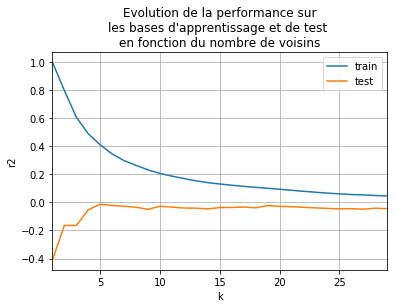

In [43]:
df_score = pd.DataFrame(dict(k=k_knn, test=test_score_knn, train=train_score_knn))
ax = df_score.plot(x='k', y='train', figsize=(6, 4))
df_score.plot(x='k', y='test', ax=ax, grid=True)
ax.set_title("Evolution de la performance sur\nles bases d'apprentissage et de test \nen fonction du nombre de voisins")
ax.set_ylabel("r2");

<h3>Régression "dummy"</h3>

Nous testons le dummy regressor (dans le GridSearchCV) qui va nous servir de comparateur pour les autres modèles, comme modèle obtenant les pires résultats. 

Pour le dummy regressor, il n'existe qu'un unique hyper-paramètre sur lequel nous pouvons jouer pour optimiser notre modèle : la stratégie utilisée pour faire le calcul. Ici, nous en sélectionnons deux différentes : la moyenne (les résultats sont égaux à la moyenne de l'échantillon train) et la médiane (les résultats sont égaux à la médiane de l'échantillon train)

Une fois le calcul effectué, nous visualisons la stratégie pour laquelle les résultats sont "optimaux".

Nous avons aussi enregistré plusieurs valeurs, comme pour chacun des modèles que nous calculerons, et en double (le train et le test), afin de comparer l'efficacité de tous les modèles testés ici : 
- le temps d'exécution du modèle (entre le tout début et la fin des predicts)
- le score : ici, nous utiliserons le R2
- la RMSE : racine carrée du carré moyen des erreurs, qui doit être la plus basse possible 
- la MAE : moyenne arithmétique des valeurs absolues des écarts

In [44]:
start_time=time.time()

parameters = {'strategy':["mean","median"]}

model = dummy.DummyRegressor()
du=GridSearchCV(cv=folds, estimator=model,param_grid=parameters,return_train_score=True)
du.fit(Xtrain_scaled,Ytrain)

dutime=time.time()-start_time

resdu = du.cv_results_
train_score_du = resdu['mean_train_score']
test_score_du = resdu['mean_test_score']

print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",du.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'strategy': 'median'}


In [45]:
print ("Valeurs pour le dummy regressor sur le train")
dupredtrain= du.predict(Xtrain_scaled)
dupredtrainrmse=np.sqrt(mean_squared_error(Ytrain,dupredtrain))
print("RMSE = ",dupredtrainrmse)
dupredtrainr2=r2_score(Ytrain, dupredtrain)
print("R2 score = ",dupredtrainr2)
dupredtrainmae= mean_absolute_error(Ytrain,dupredtrain)
print ("MAE :", dupredtrainmae)

print ("Valeurs pour le dummy regressor sur le test")
dupredtest= du.predict(Xtest_scaled)
dupredtestrmse=np.sqrt(mean_squared_error(Ytest,dupredtest))
print("RMSE = ",dupredtestrmse)
dupredtestr2=r2_score(Ytest, dupredtest)
print("R2 score = ",dupredtestr2)
dupredtestmae= mean_absolute_error(Ytest,dupredtest)
print ("MAE :", dupredtestmae)

dustats=["Dummy regressor",dupredtrainr2,dupredtrainrmse,dupredtrainmae,dupredtestr2,dupredtestrmse,dupredtestmae,dutime]

Valeurs pour le dummy regressor sur le train
RMSE =  3.15916103380312
R2 score =  -0.040111300169167086
MAE : 0.8785156250000001
Valeurs pour le dummy regressor sur le test
RMSE =  0.8211234681824653
R2 score =  -0.15740395068475221
MAE : 0.5434375


<h3>Régression linéaire</h3>

Nous testons ensuite la régression linéaire (dans le GridSearchCV) qui permet de contraindre les données à une forme de droite

Pour la régression linéaire, il existe deux hyper-paramètres sur lequel nous pouvons jouer pour optimiser notre modèle : 
- "fit_intercept" afin de savoir si on utilise ou non l'ordonnée à l'origine
- "normalize" afin de normaliser ou non le X avant la régression 

Une fois le calcul effectué, nous visualisons les hyperparamètres pour lesquels les résultats sont "optimaux".

Nous avons aussi enregistré plusieurs valeurs, comme pour chacun des modèles que nous calculerons, et en double (le train et le test), afin de comparer l'efficacité de tous les modèles testés ici : 
- le temps d'exécution du modèle (entre le tout début et la fin des predicts)
- le score : ici, nous utiliserons le R2
- la RMSE : racine carrée du carré moyen des erreurs, qui doit être la plus basse possible 
- la MAE : moyenne arithmétique des valeurs absolues des écarts

In [46]:
start_time=time.time()

parameters = {'fit_intercept':[True,False],'normalize':[True,False]}

model=linear_model.LinearRegression()
lr = GridSearchCV(cv=folds, estimator=model,param_grid=parameters,return_train_score=True)
lr.fit(Xtrain_scaled,Ytrain)

lrtime=time.time()-start_time

reslr = lr.cv_results_
train_score_lr = reslr['mean_train_score']
test_score_lr = reslr['mean_test_score']

print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",lr.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'fit_intercept': False, 'normalize': True}


In [47]:
print ("Valeurs pour la régression linéaire sur le train")
lrpredtrain= lr.predict(Xtrain_scaled)
lrpredtrainrmse=np.sqrt(mean_squared_error(Ytrain,lrpredtrain))
print("RMSE = ",lrpredtrainrmse)
lrpredtrainr2=r2_score(Ytrain, lrpredtrain)
print("R2 score = ",lrpredtrainr2)
lrpredtrainmae= mean_absolute_error(Ytrain,lrpredtrain)
print ("MAE :", lrpredtrainmae)

print ("Valeurs pour la régression linéaire sur le test")
lrpredtest= lr.predict(Xtest_scaled)
lrpredtestrmse=np.sqrt(mean_squared_error(Ytest,lrpredtest))
print("RMSE = ",lrpredtestrmse)
lrpredtestr2=r2_score(Ytest, lrpredtest)
print("R2 score = ",lrpredtestr2)
lrpredtestmae= mean_absolute_error(Ytest,lrpredtest)
print ("MAE :", lrpredtestmae)

lrstats=["Régression linéaire",lrpredtrainr2,lrpredtrainrmse,lrpredtrainmae,lrpredtestr2,lrpredtestrmse,lrpredtestmae,lrtime]

Valeurs pour la régression linéaire sur le train
RMSE =  1.6968383009906172
R2 score =  0.6999337134655095
MAE : 1.4169738858581988
Valeurs pour la régression linéaire sur le test
RMSE =  1.5576417997337804
R2 score =  -3.16488694642689
MAE : 1.4378911984372185


<h3>Regression ridge</h3>

Nous testons ensuite la regression ridge (dans le GridSearchCV) qui permet de restreindre l'amplitude des poids avec un effet de sélection groupée : les variables corrélées auront le même coefficient. Ainsi, les variables corrélées vont se combiner et se renforcer mutuellement.

Pour la regression ridge, il existe trois hyper-paramètres sur lequel nous pouvons jouer pour optimiser notre modèle : 
- "alpha" qui est la force de régularisation, afin de réduire la variance des estimations
- "fit_intercept" afin de savoir si on utilise ou non l'ordonnée à l'origine
- "normalize" afin de normaliser ou non le X avant la régression 

Une fois le calcul effectué, nous visualisons les hyperparamètres pour lesquels les résultats sont "optimaux".

Nous avons aussi enregistré plusieurs valeurs, comme pour chacun des modèles que nous calculerons, et en double (le train et le test), afin de comparer l'efficacité de tous les modèles testés ici : 
- le temps d'exécution du modèle (entre le tout début et la fin des predicts)
- le score : ici, nous utiliserons le R2
- la RMSE : racine carrée du carré moyen des erreurs, qui doit être la plus basse possible 
- la MAE : moyenne arithmétique des valeurs absolues des écarts

In [48]:
start_time=time.time()

parameters = {'alpha':alphas}

model=Ridge()
rid = GridSearchCV(cv=folds,estimator=model,param_grid=parameters,return_train_score=True)

rid.fit(Xtrain_scaled,Ytrain)

ridtime=time.time()-start_time

res_rid = rid.cv_results_
alpha_rid=res_rid["param_alpha"]
train_score_rid = res_rid['mean_train_score']
test_score_rid = res_rid['mean_test_score']

print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",rid.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'alpha': 406.158598837698}


In [49]:
print ("Valeurs pour la regression ridge sur le train")
ridpredtrain= rid.predict(Xtrain_scaled)
ridpredtrainrmse=np.sqrt(mean_squared_error(Ytrain,ridpredtrain))
print("RMSE = ",ridpredtrainrmse)
ridpredtrainr2=r2_score(Ytrain, ridpredtrain)
print("R2 score = ",ridpredtrainr2)
ridpredtrainmae= mean_absolute_error(Ytrain,ridpredtrain)
print ("MAE :", ridpredtrainmae)

print ("Valeurs pour la regression ridge sur le test")
ridpredtest= rid.predict(Xtest_scaled)
ridpredtestrmse=np.sqrt(mean_squared_error(Ytest,ridpredtest))
print("RMSE = ",ridpredtestrmse)
ridpredtestr2=r2_score(Ytest,ridpredtest)
print("R2 score = ",ridpredtestr2)
ridpredtestmae= mean_absolute_error(Ytest,ridpredtest)
print ("MAE :", ridpredtestmae)

ridstats=["Régression ridge",ridpredtrainr2,ridpredtrainrmse,ridpredtrainmae,ridpredtestr2,ridpredtestrmse,ridpredtestmae,ridtime]

Valeurs pour la regression ridge sur le train
RMSE =  2.335688556769802
R2 score =  0.43145328743037314
MAE : 0.7221227516927966
Valeurs pour la regression ridge sur le test
RMSE =  0.5235966940388911
R2 score =  0.529389272516013
MAE : 0.4144364141183937


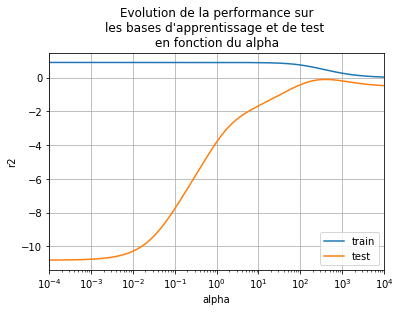

In [65]:
# Représentation graphique de la regression ridge

df_score = pd.DataFrame(dict(alpha=alpha_rid, test=test_score_rid, train=train_score_rid))
ax = df_score.plot(x='alpha', y='train', figsize=(6, 4))
ax.set_xscale('log')
df_score.plot(x='alpha', y='test', ax=ax, grid=True)
ax.set_title("Evolution de la performance sur\nles bases d'apprentissage et de test \nen fonction du alpha")
ax.set_ylabel("r2");

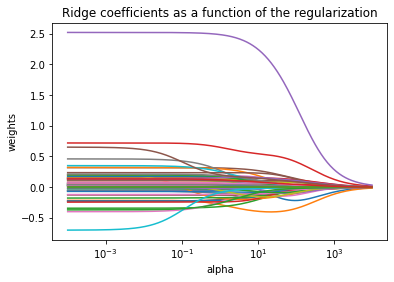

In [51]:
baseline_error = np.mean((lr.predict(Xtest_scaled) - Ytest) ** 2)

ridge = Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(Xtrain_scaled, Ytrain)
    coefs.append(ridge.coef_)
    errors.append([baseline_error, np.mean((ridge.predict(Xtest_scaled) - Ytest) ** 2)])
    
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

<h3>Lasso</h3>

Nous testons ensuite le lasso (dans le GridSearchCV) qui permet de réduire le nombre de variables : les variables qui auront un coefficient égal à zéro ne feront plus partie du modèle.

Pour le lasso, il existe deux hyper-paramètres sur lequel nous pouvons jouer pour optimiser notre modèle : 
- "alpha" qui est la force de régularisation, afin de réduire la variance des estimations
- "normalize" afin de normaliser ou non le X avant la régression 

Une fois le calcul effectué, nous visualisons les hyperparamètres pour lesquels les résultats sont "optimaux".

Nous avons aussi enregistré plusieurs valeurs, comme pour chacun des modèles que nous calculerons, et en double (le train et le test), afin de comparer l'efficacité de tous les modèles testés ici : 
- le temps d'exécution du modèle (entre le tout début et la fin des predicts)
- le score : ici, nous utiliserons le R2
- la RMSE : racine carrée du carré moyen des erreurs, qui doit être la plus basse possible 
- la MAE : moyenne arithmétique des valeurs absolues des écarts

In [52]:
start_time=time.time()

parameters = {'alpha':alphas}

model=Lasso()
las = GridSearchCV(cv=folds, estimator=model,param_grid=parameters,return_train_score=True)
las.fit(Xtrain_scaled,Ytrain)

lastime=time.time()-start_time

res_las = las.cv_results_
alpha_las=res_las["param_alpha"]
train_score_las = res_las['mean_train_score']
test_score_las = res_las['mean_test_score']

print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",las.best_params_)


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'alpha': 2.598458104929247}


In [53]:
print ("Valeurs pour le lasso sur le train")
laspredtrain= las.predict(Xtrain_scaled)
laspredtrainrmse=np.sqrt(mean_squared_error(Ytrain,laspredtrain))
print("RMSE = ",laspredtrainrmse)
laspredtrainr2=r2_score(Ytrain, laspredtrain)
print("R2 score = ",laspredtrainr2)
laspredtrainmae= mean_absolute_error(Ytrain,laspredtrain)
print ("MAE :", laspredtrainmae)

print ("Valeurs pour le lasso sur le test")
laspredtest= las.predict(Xtest_scaled)
laspredtestrmse=np.sqrt(mean_squared_error(Ytest,laspredtest))
print("RMSE = ",laspredtestrmse)
laspredtestr2=r2_score(Ytest,laspredtest)
print("R2 score = ",laspredtestr2)
laspredtestmae= mean_absolute_error(Ytest,laspredtest)
print ("MAE :", laspredtestmae)

lasstats=["Lasso",laspredtrainr2,laspredtrainrmse,laspredtrainmae,laspredtestr2,laspredtestrmse,laspredtestmae,lastime]

Valeurs pour le lasso sur le train
RMSE =  3.07740116839033
R2 score =  0.013028719748378936
MAE : 1.0877958120046878
Valeurs pour le lasso sur le test
RMSE =  0.8252474133845297
R2 score =  -0.16905885180364977
MAE : 0.7281075387661617


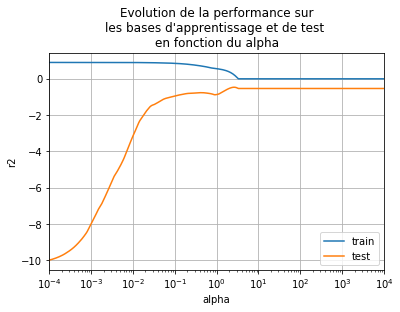

In [66]:
#Représentation graphique du lasso

df_score = pd.DataFrame(dict(alpha=alpha_las, test=test_score_las, train=train_score_las))
ax = df_score.plot(x='alpha', y='train', figsize=(6, 4))
ax.set_xscale('log')
df_score.plot(x='alpha', y='test', ax=ax, grid=True)
ax.set_title("Evolution de la performance sur\nles bases d'apprentissage et de test \nen fonction du alpha")
ax.set_ylabel("r2");

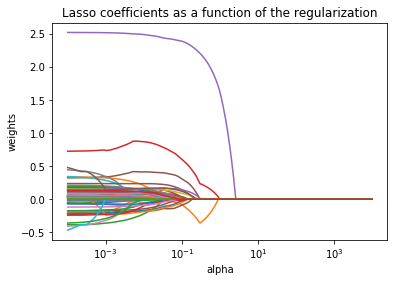

In [55]:
baseline_error = np.mean((lr.predict(Xtest_scaled) - Ytest) ** 2)

lasso = Lasso()

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xtrain_scaled, Ytrain)
    coefs.append(lasso.coef_)
    errors.append([baseline_error, np.mean((lasso.predict(Xtest_scaled) - Ytest) ** 2)])
    
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

<h3>SVR (Epsilon-Support Vector Regression)</h3>

Nous testons ensuite le SVR (dans le GridSearchCV) qui permet de prédire une variable continue, en essayant de se caler au mieux sur une ligne d'erreur seuil. Pour cela, un SVR classifie toutes les prédictions en deux catégories : celles restant dans le domaine d'erreur, et celles ne le respectant pas.

Pour le lasso, il existe trois hyper-paramètres sur lesquels nous pouvons jouer pour optimiser notre modèle : 
- le kernel est le noyau utilisé pour effectuer le calcul dans le modèle
- "C" ou le paramètre d'erreur
- "gamma" ou le coefficient du kernel. Plus il est haut et plus chaque valeur d'entraînement est forte.

Une fois le calcul effectué, nous visualisons les hyperparamètres pour lesquels les résultats sont "optimaux".

Nous avons aussi enregistré plusieurs valeurs, comme pour chacun des modèles que nous calculerons, et en double (le train et le test), afin de comparer l'efficacité de tous les modèles testés ici : 
- le temps d'exécution du modèle (entre le tout début et la fin des predicts)
- le score : ici, nous utiliserons le R2
- la RMSE : racine carrée du carré moyen des erreurs, qui doit être la plus basse possible 
- la MAE : moyenne arithmétique des valeurs absolues des écarts

In [56]:
start_time=time.time()

parameters = {'kernel':['linear','poly','rbf','sigmoid']}

model=svm.SVR()
svr_model = GridSearchCV(cv=folds, estimator=model,param_grid=parameters,return_train_score=True)
svr_model.fit(Xtrain_scaled,Ytrain)

svrtime=time.time()-start_time

res_svr= svr_model.cv_results_
train_score_svr= res_svr['mean_train_score']
test_score_svr = res_svr['mean_test_score']
#C_svr=res_svr['param_C']
#gamma_svr=res_svr['param_gamma']

print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",svr_model.best_params_)


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'kernel': 'sigmoid'}


In [57]:
print ("Valeurs pour le SVR sur le train")
svrpredtrain= svr_model.predict(Xtrain_scaled)
svrpredtrainrmse=np.sqrt(mean_squared_error(Ytrain,svrpredtrain))
print("RMSE = ",svrpredtrainrmse)
svrpredtrainr2=r2_score(Ytrain, svrpredtrain)
print("R2 score = ",svrpredtrainr2)
svrpredtrainmae= mean_absolute_error(Ytrain,svrpredtrain)
print ("MAE :", svrpredtrainmae)

print ("Valeurs pour le SVR sur le test")
svrpredtest= svr_model.predict(Xtest_scaled)
svrpredtestrmse=np.sqrt(mean_squared_error(Ytest,svrpredtest))
print("RMSE = ",svrpredtestrmse)
svrpredtestr2=r2_score(Ytest,svrpredtest)
print("R2 score = ",svrpredtestr2)
svrpredtestmae= mean_absolute_error(Ytest,svrpredtest)
print ("MAE :", svrpredtestmae)

svrstats=["SVR",svrpredtrainr2,svrpredtrainrmse,svrpredtrainmae,svrpredtestr2,svrpredtestrmse,svrpredtestmae,svrtime]

Valeurs pour le SVR sur le train
RMSE =  2.8304241161367485
R2 score =  0.16509066180743082
MAE : 0.5733706050731338
Valeurs pour le SVR sur le test
RMSE =  0.4929269551292008
R2 score =  0.5829067452872393
MAE : 0.30056971682019484


<h3>MLP (Multi-layer Perceptron regressor)</h3>

Nous testons ensuite le MLP (dans le GridSearchCV) qui utilise un réseau de neurones à propagation avant. il prend donc les échantillons d'entrée et utilise des couches de neurones pour effectuer les calculs.

Pour le MLP, il existe 4 hyper-paramètres sur lesquels nous pouvons jouer pour optimiser notre modèle : 
- 'hidden_layer_sizes' ou le nombre de couches et le nombre de neurones de chaque couche
- "activation" ou les différents types de fonctions des couches renvoyant différentes fonctions
- "solver" pour l'optimisation des poids
- "alpha" qui est la force de régularisation, afin de réduire la variance des estimations

Une fois le calcul effectué, nous visualisons les hyperparamètres pour lesquels les résultats sont "optimaux".

Nous avons aussi enregistré plusieurs valeurs, comme pour chacun des modèles que nous calculerons, et en double (le train et le test), afin de comparer l'efficacité de tous les modèles testés ici : 
- le temps d'exécution du modèle (entre le tout début et la fin des predicts)
- le score : ici, nous utiliserons le R2
- la RMSE : racine carrée du carré moyen des erreurs, qui doit être la plus basse possible 
- la MAE : moyenne arithmétique des valeurs absolues des écarts

In [58]:
start_time=time.time()

parameters = {'hidden_layer_sizes':[(50,),(50,50)],'activation':['identity','logistic','tanh','relu'],'solver':['lbfgs','adam']}
model=MLPRegressor()
mlp=GridSearchCV(cv=folds, estimator=model,param_grid=parameters,return_train_score=True)
mlp.fit(Xtrain_scaled,Ytrain)

mlptime=time.time()-start_time

res_mlp= mlp.cv_results_
train_score_mlp= res_mlp['mean_train_score']
test_score_mlp = res_mlp['mean_test_score']

print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",mlp.best_params_)


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'activation': 'logistic', 'hidden_layer_sizes': (50, 50), 'solver': 'adam'}


In [59]:
print ("Valeurs pour le MLP sur le train")
mlppredtrain= mlp.predict(Xtrain_scaled)
mlppredtrainrmse=np.sqrt(mean_squared_error(Ytrain,mlppredtrain))
print("RMSE = ",mlppredtrainrmse)
mlppredtrainr2=r2_score(Ytrain, mlppredtrain)
print("R2 score = ",mlppredtrainr2)
mlppredtrainmae= mean_absolute_error(Ytrain,mlppredtrain)
print ("MAE :", mlppredtrainmae)

print ("Valeurs pour le MLP sur le test")
mlppredtest= mlp.predict(Xtest_scaled)
mlppredtestrmse=np.sqrt(mean_squared_error(Ytest,mlppredtest))
print("RMSE = ",mlppredtestrmse)
mlppredtestr2=r2_score(Ytest,mlppredtest)
print("R2 score = ",mlppredtestr2)
mlppredtestmae= mean_absolute_error(Ytest,mlppredtest)
print ("MAE :", mlppredtestmae)

mlpstats=["MLP",mlppredtrainr2,mlppredtrainrmse,mlppredtrainmae,mlppredtestr2,mlppredtestrmse,mlppredtestmae,mlptime]

Valeurs pour le MLP sur le train
RMSE =  2.7366698449851374
R2 score =  0.21948527590723044
MAE : 0.5794434551088901
Valeurs pour le MLP sur le test
RMSE =  0.7768050284162454
R2 score =  -0.03583859209797691
MAE : 0.5280687020281333


<h3>Random Forest</h3>

Nous testons enfin le RF (dans le GridSearchCV) qui combine de multiples arbres de décision pour fusionner leurs prédictions afin d'obtenir une prédiction finale plus stable et précis.

Pour le RF, il existe 3 hyper-paramètres sur lesquels nous pouvons jouer pour optimiser notre modèle : 
- Le nombre d'estimateurs est le nombre d'arbres de décision utilisés
- Le criterion est la fonction mesurant la qualité d'une décision
- La profondeur maximale des arbres

Une fois le calcul effectué, nous visualisons plusieurs indications :
- La stratégie pour laquelle les résultats sont "optimaux"
- Le score correspondant à chaque stratégie
- Le score correspondant à chacun des 5 tours demandés par la cross-validation, afin de confirmer que la répartition des échantillons se fait de manière homogène

Nous avons aussi enregistré plusieurs valeurs, comme pour chacun des modèles que nous calculerons, et en double (le train et le test), afin de comparer l'efficacité de tous les modèles testés ici : 
- le temps d'exécution du modèle (entre le tout début et la fin des predicts)
- le score : ici, nous utiliserons le R2
- la RMSE : racine carrée du carré moyen des erreurs, qui doit être la plus basse possible 
- la MAE : moyenne arithmétique des valeurs absolues des écarts

In [60]:
start_time=time.time()

parameters = {'n_estimators':[50,100,200],'max_depth':[30,50],"criterion":["mse"]}

model=RandomForestRegressor()
rf = GridSearchCV(cv=folds, estimator=model,param_grid=parameters,return_train_score=True)
rf.fit(Xtrain_scaled,Ytrain)

rftime=time.time()-start_time

res_rf= rf.cv_results_
train_score_rf= res_rf['mean_train_score']
test_score_rf = res_rf['mean_test_score']

print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",rf.best_params_)


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'criterion': 'mse', 'max_depth': 30, 'n_estimators': 100}


In [61]:
print ("Valeurs pour le Random Forest sur le train")
rfpredtrain= rf.predict(Xtrain_scaled)
rfpredtrainrmse=np.sqrt(mean_squared_error(Ytrain,rfpredtrain))
print("RMSE = ",rfpredtrainrmse)
rfpredtrainr2=r2_score(Ytrain, rfpredtrain)
print("R2 score = ",rfpredtrainr2)
rfpredtrainmae= mean_absolute_error(Ytrain,rfpredtrain)
print ("MAE :", rfpredtrainmae)


print ("Valeurs pour le Random Forest sur le test")
rfpredtest= rf.predict(Xtest_scaled)
rfpredtestrmse=np.sqrt(mean_squared_error(Ytest,rfpredtest))
print("RMSE = ",rfpredtestrmse)
rfpredtestr2=r2_score(Ytest,rfpredtest)
print("R2 score = ",rfpredtestr2)
rfpredtestmae= mean_absolute_error(Ytest,rfpredtest)
print ("MAE :", rfpredtestmae)

rfstats=["Random Forest",rfpredtrainr2,rfpredtrainrmse,rfpredtrainmae,rfpredtestr2,rfpredtestrmse,rfpredtestmae,rftime]


Valeurs pour le Random Forest sur le train
RMSE =  1.095034384413055
R2 score =  0.8750340199698732
MAE : 0.23133046875000032
Valeurs pour le Random Forest sur le test
RMSE =  0.19679038657922274
R2 score =  0.933522330077557
MAE : 0.13776874999999988


<h3>Comparaison des modèles</h3>

Maintenant que nous avons fait tourné tous les modèles pouvant être intéressants pour nos données afin d'obtenir la consommation totale d'énergie par pied carré, nous les comparons pour sélectionner le plus adapté.

Le modèle le plus adapté est donc un modèle possédant un haut score, des valeurs d'erreur basses, ainsi qu'un temps d'exécution correct.

Les plus hauts scores sont obtenus avec les modèles de régression linéaire et de MLP. Or, la régression linéaire donne des erreurs plus faibles et un temps d'exécution beaucoup plus rapide : ce sera donc le modèle sélectionné pour calculer la consommation totale d'énergie par pied carré.

In [62]:
statsnom=["Score train","RMSE train","MAE train","Score test","RMSE test","MAE test","Temps d'exécution"]
stats=[statsnom,dustats,knnstats,lrstats,ridstats,lasstats,svrstats,mlpstats,rfstats]

modeles=["Dummy regressor","kNN","Régression linéaire","Regression ridge","Lasso","SVR","MLP","Random Forest"]
scoretrain=[dupredtrainr2,knnpredtrainr2,lrpredtrainr2,ridpredtrainr2,laspredtrainr2,svrpredtrainr2,mlppredtrainr2,rfpredtrainr2]
scoretest=[dupredtestr2,knnpredtestr2,lrpredtestr2,ridpredtestr2,laspredtestr2,svrpredtestr2,mlppredtestr2,rfpredtestr2]

rmsetrain=[dupredtrainrmse,knnpredtrainrmse,lrpredtrainrmse,ridpredtrainrmse,laspredtrainrmse,svrpredtrainrmse,mlppredtrainrmse,rfpredtrainrmse]
rmsetest=[dupredtestrmse,knnpredtestrmse,lrpredtestrmse,ridpredtestrmse,laspredtestrmse,svrpredtestrmse,mlppredtestrmse,rfpredtestrmse]

maetrain=[dupredtrainmae,knnpredtrainmae,lrpredtrainmae,ridpredtrainmae,laspredtrainmae,svrpredtrainmae,mlppredtrainmae,rfpredtrainmae]
maetest=[dupredtestmae,knnpredtestmae,lrpredtestmae,ridpredtestmae,laspredtestmae,svrpredtestmae,mlppredtestmae,rfpredtestmae]

time=[dutime,knntime,lrtime,ridtime,lastime,svrtime,mlptime,rftime]


datamodeles=pd.DataFrame(dict(modeles=modeles, scoretrain=scoretrain,scoretest=scoretest,rmsetrain=rmsetrain,rmsetest=rmsetest,maetrain=maetrain,maetest=maetest,time=time))

print (datamodeles.iloc[:,[0,1,2]])
print ()
print (datamodeles.iloc[:,[0,3,4]])
print ()
print (datamodeles.iloc[:,[0,5,6]])
print ()
print (datamodeles.iloc[:,[0,7]])

               modeles  scoretrain  scoretest
0      Dummy regressor   -0.040111  -0.157404
1                  kNN    0.406311   0.541367
2  Régression linéaire    0.699934  -3.164887
3     Regression ridge    0.431453   0.529389
4                Lasso    0.013029  -0.169059
5                  SVR    0.165091   0.582907
6                  MLP    0.219485  -0.035839
7        Random Forest    0.875034   0.933522

               modeles  rmsetrain  rmsetest
0      Dummy regressor   3.159161  0.821123
1                  kNN   2.386774  0.516891
2  Régression linéaire   1.696838  1.557642
3     Regression ridge   2.335689  0.523597
4                Lasso   3.077401  0.825247
5                  SVR   2.830424  0.492927
6                  MLP   2.736670  0.776805
7        Random Forest   1.095034  0.196790

               modeles  maetrain   maetest
0      Dummy regressor  0.878516  0.543438
1                  kNN  0.624047  0.353063
2  Régression linéaire  1.416974  1.437891
3     Regression

<h3>Optimisation du modèle choisi</h3>

In [63]:

print ("\nScores après chaque pli test (ici 5) :")
best_estim_place = np.where(rf.cv_results_['rank_test_score'] == 1)[0][0] 
for i in range(5):    
  print(str(i)," : ",rf.cv_results_['split' + str(i) + '_test_score'][best_estim_place])



Scores après chaque pli test (ici 5) :
0  :  0.07237633783976116
1  :  0.6639534991648274
2  :  0.7385132594916838
3  :  0.7126319971633113
4  :  -1.3296524438282438


In [68]:
print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement sur le RF précédent :",rf.best_params_)

start_time=time.time()
estim= [i for i in np.arange(90,112,2)]
depth=[i for i in np.arange(20,42,2)]

parameters = {'criterion':['mse'],'n_estimators':estim,'max_depth':depth}

model=RandomForestRegressor()
rfopti = GridSearchCV(cv=folds, estimator=model,param_grid=parameters,return_train_score=True)
rfopti.fit(Xtrain_scaled,Ytrain)

rftime=time.time()-start_time

res_rf= rfopti.cv_results_
train_score_rf= res_rf['mean_train_score']
test_score_rf = res_rf['mean_test_score']

print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",rfopti.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement sur le RF précédent : {'criterion': 'mse', 'max_depth': 30, 'n_estimators': 100}
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'criterion': 'mse', 'max_depth': 38, 'n_estimators': 92}


In [69]:
print ("Valeurs pour le Random Forest sur le train")
rfpredtrain= rfopti.predict(Xtrain_scaled)
rfpredtrainrmse=np.sqrt(mean_squared_error(Ytrain,rfpredtrain))
print("RMSE = ",rfpredtrainrmse)
rfpredtrainr2=r2_score(Ytrain, rfpredtrain)
print("R2 score = ",rfpredtrainr2)
rfpredtrainmae= mean_absolute_error(Ytrain,rfpredtrain)
print ("MAE :", rfpredtrainmae)


print ("Valeurs pour le Random Forest sur le test")
rfpredtest= rfopti.predict(Xtest_scaled)
rfpredtestrmse=np.sqrt(mean_squared_error(Ytest,rfpredtest))
print("RMSE = ",rfpredtestrmse)
rfpredtestr2=r2_score(Ytest,rfpredtest)
print("R2 score = ",rfpredtestr2)
rfpredtestmae= mean_absolute_error(Ytest,rfpredtest)
print ("MAE :", rfpredtestmae)



Valeurs pour le Random Forest sur le train
RMSE =  1.0692754012407695
R2 score =  0.8808441309115888
MAE : 0.2334408967391306
Valeurs pour le Random Forest sur le test
RMSE =  0.2553529904894209
R2 score =  0.8880691175441691
MAE : 0.17158288043478256
